In [1]:
import os
import re
import numpy as np
import pandas as pd

In [2]:
def get_filename_list(path, data_name):
    files_list = []
    #print(f"完整扫描目录: {path}")
    
    # 显示目录结构用于调试
    for root, dirs, files in os.walk(path):
        #print(f"\n当前目录: {root}")
        #print("子目录:", [d for d in dirs if 'rep=' in d or 'baseline_jce=' in d])
        #print("文件:", [f for f in files if data_name in f])
        
        for file in files:
            if data_name in file and (file.endswith('.csv') or file.endswith('.gz')):
                try:
                    parts = root.split(os.sep)
                    
                    # 提取参数
                    rep = next((p.split('=')[1] for p in parts if p.startswith('rep=')), '000')
                    baseline_jce = next((p.split('=')[1] for p in parts if 'baseline_jce=' in p), '000.010050')
                    decay_jce = next((p.split('=')[1] for p in parts if 'decay_jce=' in p), '0000000001')
                    
                    files_list.append((
                        "neutral+niche+rapid_evolution", "sexual", "16",
                        baseline_jce, decay_jce, "0.00001",
                        rep,
                        os.path.join(root, file)
                    ))
                    
                except Exception as e:
                    print(f"跳过文件 {file} (错误: {str(e)})")
    
    #print(f"\n最终找到 {len(files_list)} 个匹配文件")
    if len(files_list) == 0:
        print("警告：未找到任何文件！请检查：")
        print(f"1. 路径是否正确: {path}")
        print(f"2. 文件名是否包含: {data_name}")
        print("3. 目录结构是否符合预期")
    
    return files_list
def inverse_Simpson_index(sp_num_array):
    N = sp_num_array.sum()
    inverse_simpson_index = 0
    for sp_num in sp_num_array:
        inverse_simpson_index += (sp_num*(sp_num-1))/(N*(N-1))
    return 1/inverse_simpson_index

def Shannon_diversity(sp_num_array):
    N = sp_num_array.sum()
    shannon_diversity = 0
    for sp_num in sp_num_array:
        shannon_diversity += sp_num/N * np.log(sp_num/N)
    return -1*shannon_diversity

def Hill_number(sp_num_array, a):
    N = sp_num_array.sum()
    if N==0: return 0
    if a==1: return np.exp(Shannon_diversity(sp_num_array))
    hill_num = 0
    for sp_num in sp_num_array:
        hill_num += np.power(sp_num/N, a)
    return np.power(hill_num, 1/(1-a))

def habitat_diversity(df, time_step, patch_num, hab_num, hill_index=2):
    if time_step is None:
        available_steps = [int(s.split('_')[1]) for s in df.index if '_' in str(s)]
        closest_step = min(available_steps, key=lambda x: abs(x-499))
        time_step = f'time_step{closest_step}'
        print(f"自动选择时间步: {time_step}")

    if time_step not in df.index:
        available_steps = sorted([s for s in df.index if '_' in str(s)])
        raise ValueError(
            f"时间步 {time_step} 不存在\n"
            f"可用时间步: {available_steps[:5]}...{available_steps[-5:]}"
        )    
    patch_diversity_list = []
    for patch_id in ['patch%d' % (i+1) for i in range(patch_num)]:
        for habitat_id in ['h%d' % i for i in range(hab_num)]:
            species_num_array = df.loc[time_step][patch_id][habitat_id].value_counts().to_numpy()
            try:
                #habitat_diversity = inverse_Simpson_index(species_num_array)
                habitat_diversity = Hill_number(sp_num_array=species_num_array, a=hill_index)
            except:
                habitat_diversity = np.nan
            patch_diversity_list.append(habitat_diversity)
    return np.array(patch_diversity_list).reshape(patch_num*hab_num,1)

def patch_diversity(df, time_step, patch_num, hill_index=2):
    patch_diversity_list = []
    for patch_id in ['patch%d' % (i+1) for i in range(patch_num)]:
        species_num_array = df.loc[time_step][patch_id].value_counts().to_numpy()
        try:
            #patch_diversity = inverse_Simpson_index(species_num_array)
            patch_diversity = Hill_number(sp_num_array=species_num_array, a=hill_index)
        except:
            patch_diversity = np.nan
        patch_diversity_list.append(patch_diversity)
    return np.array(patch_diversity_list).reshape(patch_num,1)

def global_diversity(df, time_step, hill_index=2):
    species_num_array = df.loc[time_step].value_counts().to_numpy()
    try:
        global_diversity = Hill_number(sp_num_array=species_num_array, a=hill_index)
    except:
        global_diversity = np.nan
    return np.array([global_diversity]).reshape(-1,1)

def cumulative_species_richness_curve(df, time_step):
    cumulative_species = []
    new_species_area_index = []
    index = 1
    for sp_id in df.loc[time_step].to_numpy():
        if sp_id not in cumulative_species and not np.isnan(sp_id):

            cumulative_species.append(sp_id)
            new_species_area_index.append(index)
        else:
            pass
        index += 1
    return np.array(new_species_area_index).reshape(-1,1)

def hstack_fillup(array_1, array_2):
    
    if array_1.shape[0]>array_2.shape[0]:
        array_2 = np.vstack((array_2, np.nan*np.ones((array_1.shape[0]-array_2.shape[0],array_2.shape[1]))))
    elif array_1.shape[0]<array_2.shape[0]:
        array_1 = np.vstack((array_1, np.nan*np.ones((array_2.shape[0]-array_1.shape[0], array_1.shape[1]))))
        
    return np.hstack((array_1, array_2))


In [3]:
files_list = get_filename_list(path=r'D:\大学文件\metaibm\metaibm.self\并行', data_name='meta_species_distribution_all_time')


In [4]:
header = [np.array([]),    # scenario
          np.array([]),    # reproduce_mode
          np.array([]),    # patch_num 
          np.array([]),    # disp_among_rate
          np.array([]),    # disp_within_rate
          np.array([]),    # patch_dist_rate
          np.array([])]    # rep

In [5]:
species_index = ['sp%d'%i for i in range(1,101)]
#patch_index = ['patch%d'%i for i in range(1,101)]
patch_index = ['patch%d'%i for i in range(1,17)]
patch_habitat_index=pd.MultiIndex.from_arrays([['patch%d'%i for i in range(1,17) for j in range(4)],['h0', 'h1', 'h2', 'h3']*16])
global_index = ['global']


In [6]:
all_PD_hill0, all_PD_hill1, all_PD_hill2 = np.empty((0,0)), np.empty((0,0)), np.empty((0,0))
all_HD_hill0, all_HD_hill1, all_HD_hill2 = np.empty((0,0)), np.empty((0,0)), np.empty((0,0))
all_GD_hill0, all_GD_hill1, all_GD_hill2 = np.empty((0,0)), np.empty((0,0)), np.empty((0,0))
all_CSR = np.empty((0,0))

In [7]:


counter = 0
for file in files_list:
    counter += 1
    print(counter, file[0], file[1], file[2], file[3], file[4], file[5], file[6])
    
    header = [np.append(header[0], file[0]),       # scenario
              np.append(header[1], file[1]),       # reproduce_mode
              np.append(header[2], file[2]),       # patch_num 
              np.append(header[3], file[3]),       # disp_among_rate
              np.append(header[4], file[4]),       # disp_within_rate
              np.append(header[5], file[5]),       # patch_dist_rate
              np.append(header[6], file[6])]       # rep  
    
    file_name = file[7]
    df = pd.read_csv(file_name, compression='gzip', header=[0,1,2], index_col=[0], skiprows=lambda x: x>=3 and x<=502,skip_blank_lines=False)
    #print(df.head())
    if 'time_step499' not in df.index:
    # 如果不存在，添加 time_step499 行，并填充全为 NaN 的数据
        df.loc['time_step499'] = np.nan
        print("time_step499 行已添加并填充为 NaN")
    else:
        print("time_step499 行已存在")
    # 检查形状
    #print(np.array(all_PD_hill0).shape)  # 应该是 (16, 7)
    #print(len(patch_index))  # 应该是 100
    #print(len(header))  # 应该是 36


    habitat_diversity_res_hill0 = habitat_diversity(df, time_step='time_step499', patch_num=int(file[2]), hab_num=4, hill_index=0)
    habitat_diversity_res_hill1 = habitat_diversity(df, time_step='time_step499', patch_num=int(file[2]), hab_num=4, hill_index=1)
    habitat_diversity_res_hill2 = habitat_diversity(df, time_step='time_step499', patch_num=int(file[2]), hab_num=4, hill_index=2)
    
    patch_diversity_res_hill0 = patch_diversity(df, time_step='time_step499', patch_num=int(file[2]), hill_index=0)
    patch_diversity_res_hill1 = patch_diversity(df, time_step='time_step499', patch_num=int(file[2]), hill_index=1)
    patch_diversity_res_hill2 = patch_diversity(df, time_step='time_step499', patch_num=int(file[2]), hill_index=2)

    global_diversity_res_hill0 = global_diversity(df, time_step='time_step499', hill_index=0)
    global_diversity_res_hill1 = global_diversity(df, time_step='time_step499', hill_index=1)
    global_diversity_res_hill2 = global_diversity(df, time_step='time_step499', hill_index=2)
    
    cumulative_species_richness_curve_res = cumulative_species_richness_curve(df, time_step='time_step499')
    
    all_PD_hill0 = hstack_fillup(all_PD_hill0, patch_diversity_res_hill0)
    all_PD_hill1 = hstack_fillup(all_PD_hill1, patch_diversity_res_hill1)
    all_PD_hill2 = hstack_fillup(all_PD_hill2, patch_diversity_res_hill2)
    all_HD_hill0 = hstack_fillup(all_HD_hill0, habitat_diversity_res_hill0)
    all_HD_hill1 = hstack_fillup(all_HD_hill1, habitat_diversity_res_hill1)
    all_HD_hill2 = hstack_fillup(all_HD_hill2, habitat_diversity_res_hill2)
    all_GD_hill0 = hstack_fillup(all_GD_hill0, global_diversity_res_hill0)
    all_GD_hill1 = hstack_fillup(all_GD_hill1, global_diversity_res_hill1)
    all_GD_hill2 = hstack_fillup(all_GD_hill2, global_diversity_res_hill2)
    all_CSR = hstack_fillup(all_CSR, cumulative_species_richness_curve_res)
    
    #print(patch_diversity_res_hill0.shape, patch_diversity_res_hill1.shape, patch_diversity_res_hill2.shape)
    #print(habitat_diversity_res_hill0.shape, habitat_diversity_res_hill1.shape, habitat_diversity_res_hill2.shape)
    #print(cumulative_species_richness_curve_res.shape)

1 neutral+niche+rapid_evolution sexual 16 000.010050 0000000001 0.00001 000
time_step499 行已存在
2 neutral+niche+rapid_evolution sexual 16 000.010050 0000000005 0.00001 000
time_step499 行已存在
3 neutral+niche+rapid_evolution sexual 16 000.010050 0000000010 0.00001 000
time_step499 行已存在
4 neutral+niche+rapid_evolution sexual 16 000.010050 0000000015 0.00001 000
time_step499 行已存在
5 neutral+niche+rapid_evolution sexual 16 000.356000 0000000001 0.00001 000
time_step499 行已存在
6 neutral+niche+rapid_evolution sexual 16 000.356000 0000000005 0.00001 000
time_step499 行已存在
7 neutral+niche+rapid_evolution sexual 16 000.356000 0000000010 0.00001 000
time_step499 行已存在
8 neutral+niche+rapid_evolution sexual 16 000.356000 0000000015 0.00001 000
time_step499 行已存在
9 neutral+niche+rapid_evolution sexual 16 000.510000 0000000001 0.00001 000
time_step499 行已存在
10 neutral+niche+rapid_evolution sexual 16 000.510000 0000000005 0.00001 000
time_step499 行已存在
11 neutral+niche+rapid_evolution sexual 16 000.510000 00000

In [33]:
print(all_PD_hill0)

[[ 5.  8.  8. ...  1.  0.  0.]
 [ 5. 10.  9. ...  2.  0.  0.]
 [ 6.  7. 11. ...  2.  1.  0.]
 ...
 [ 6. 10. 17. ...  3.  0.  0.]
 [ 7. 10. 12. ...  0.  0.  0.]
 [ 4. 10. 13. ...  3.  0.  0.]]


In [34]:
header

[array(['neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution', 'neutral+niche+rapid_evolution',
        'neutral+niche+rapid_evolution

In [27]:
print(patch_index)

['patch1', 'patch2', 'patch3', 'patch4', 'patch5', 'patch6', 'patch7', 'patch8', 'patch9', 'patch10', 'patch11', 'patch12', 'patch13', 'patch14', 'patch15', 'patch16']


In [9]:
df_all_PD_hill0 = pd.DataFrame(all_PD_hill0, index=patch_index, columns=header)
df_all_PD_hill1 = pd.DataFrame(all_PD_hill1, index=patch_index, columns=header)
df_all_PD_hill2 = pd.DataFrame(all_PD_hill2, index=patch_index, columns=header)
df_all_HD_hill0 = pd.DataFrame(all_HD_hill0, index=patch_habitat_index, columns=header)
df_all_HD_hill1 = pd.DataFrame(all_HD_hill1, index=patch_habitat_index, columns=header)
df_all_HD_hill2 = pd.DataFrame(all_HD_hill2, index=patch_habitat_index, columns=header)
df_all_GD_hill0 = pd.DataFrame(all_GD_hill0, index=global_index, columns=header)
df_all_GD_hill1 = pd.DataFrame(all_GD_hill1, index=global_index, columns=header)
df_all_GD_hill2 = pd.DataFrame(all_GD_hill2, index=global_index, columns=header)
#df_all_CSR = pd.DataFrame(all_CSR, index=species_index, columns=header)
    
df_all_PD_hill0.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_PD_hill1.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_PD_hill2.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_HD_hill0.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_HD_hill1.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_HD_hill2.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_GD_hill0.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_GD_hill1.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_GD_hill2.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
#df_all_CSR.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']

df_all_PD_hill0.to_csv('all_patch_diversity_hill0.csv')   
df_all_PD_hill1.to_csv('all_patch_diversity_hill1.csv')  
df_all_PD_hill2.to_csv('all_patch_diversity_hill2.csv')  
df_all_HD_hill0.to_csv('all_habitat_diversity_hill0.csv')  
df_all_HD_hill1.to_csv('all_habitat_diversity_hill1.csv')  
df_all_HD_hill2.to_csv('all_habitat_diversity_hill2.csv')  
df_all_GD_hill0.to_csv('all_global_diversity_hill0.csv')  
df_all_GD_hill1.to_csv('all_global_diversity_hill1.csv')  
df_all_GD_hill2.to_csv('all_global_diversity_hill2.csv')  
#df_all_CSR.to_csv('all_culmulative_species_richness_curves.csv')

In [ ]:
all_CSR = np.empty((0,0))
counter = 0
for file in files_list:
    counter += 1
    print(counter, file[0], file[1], file[2], file[3], file[4], file[5], file[6])
    
    header = [np.append(header[0], file[0]),       # scenario
              np.append(header[1], file[1]),       # reproduce_mode
              np.append(header[2], file[2]),       # patch_num 
              np.append(header[3], file[3]),       # disp_among_rate
              np.append(header[4], file[4]),       # disp_within_rate
              np.append(header[5], file[5]),       # patch_dist_rate
              np.append(header[6], file[6])]       # rep  
    
    file_name = file[7]
    df = pd.read_csv(file_name, compression='gzip', header=[0,1,2], index_col=[0], skiprows=lambda x: x>=3 and x<=502,skip_blank_lines=False)
    #print(df.head())
    if 'time_step499' not in df.index:
    # 如果不存在，添加 time_step499 行，并填充全为 NaN 的数据
        df.loc['time_step499'] = np.nan
        print("time_step499 行已添加并填充为 NaN")
    else:
        print("time_step499 行已存在")
    # 检查形状
    #print(np.array(all_PD_hill0).shape)  # 应该是 (16, 7)
    #print(len(patch_index))  # 应该是 100
    #print(len(header))  # 应该是 36



    
    cumulative_species_richness_curve_res = cumulative_species_richness_curve(df, time_step='time_step499')
    #print(cumulative_species_richness_curve_res)

    all_CSR = hstack_fillup(all_CSR, cumulative_species_richness_curve_res)
    

species_index = species_index[:len(all_CSR)]
df_all_CSR = pd.DataFrame(all_CSR, index=species_index, columns=header)
df_all_CSR = pd.DataFrame(all_CSR, index=species_index, columns=header)
df_all_CSR.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_CSR.to_csv('all_culmulative_species_richness_curves.csv')

In [10]:
species_index = species_index[:len(all_CSR)]
df_all_CSR = pd.DataFrame(all_CSR, index=species_index, columns=header)
df_all_CSR = pd.DataFrame(all_CSR, index=species_index, columns=header)
df_all_CSR.columns.names = ['scenario', 'reproduce_mode', 'patch_num', 'disp_among_rate', 'disp_within_rate', 'patch_dist_rate', 'rep']
df_all_CSR.to_csv('all_culmulative_species_richness_curves.csv')

In [21]:
import matplotlib.pyplot as plt

In [ ]:


# 计算每个时间步长的累积物种丰富度
cumulative_species_counts = []

new_species_indices = cumulative_species_richness_curve(df, "time_step499")
cumulative_species_counts.append(len(new_species_indices))

# 将结果转换为 Pandas Series
cumulative_species_series = pd.Series(cumulative_species_counts, index=range(len(df)))

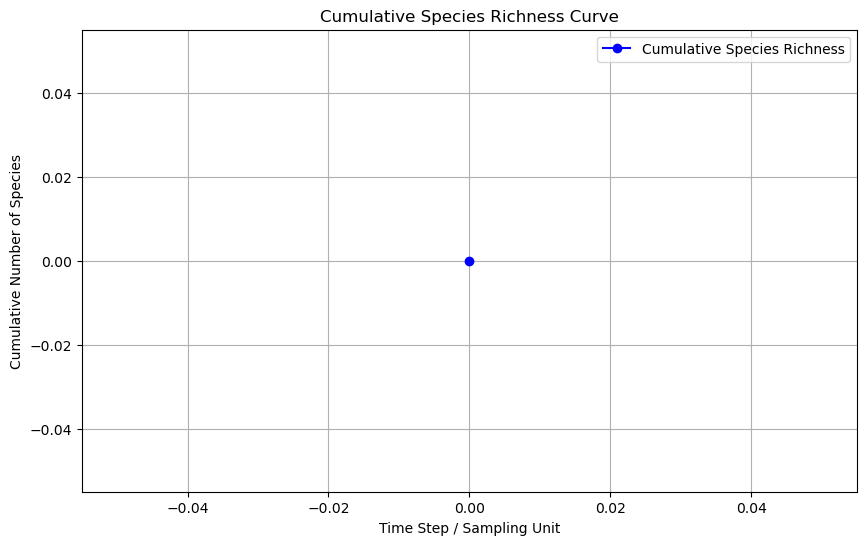

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_species_series.index, cumulative_species_series.values, marker='o', linestyle='-', color='b')

# 添加标题和标签
plt.title('Cumulative Species Richness Curve')
plt.xlabel('Time Step / Sampling Unit')
plt.ylabel('Cumulative Number of Species')

# 显示网格
plt.grid(True)

# 显示图例
plt.legend(['Cumulative Species Richness'])

# 显示图表
plt.show()

C:\Users\pwy23\AppData\Local\Temp\ipykernel_22356\2926141743.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  species_data = species_data.fillna(method='ffill')


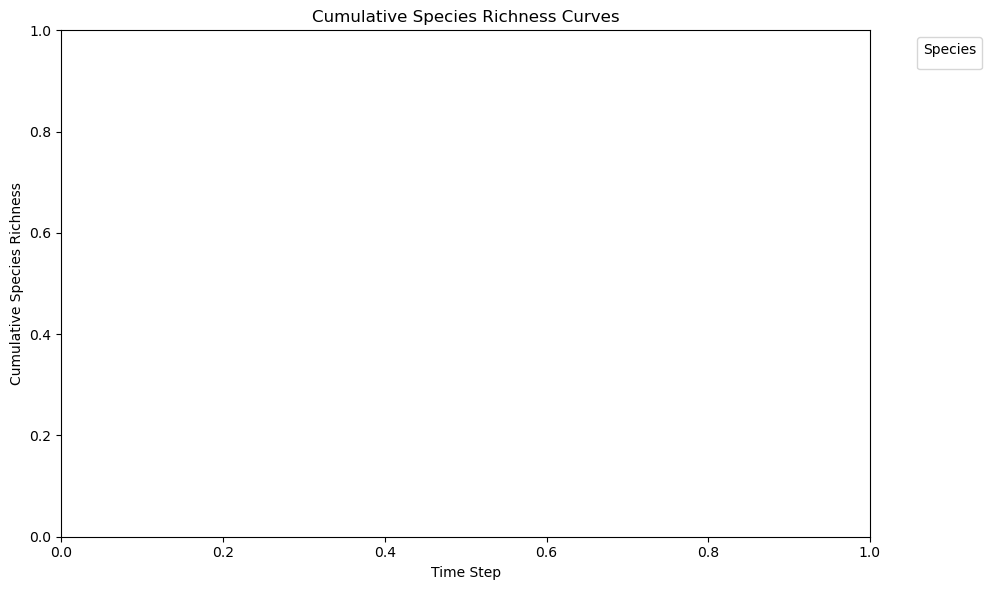

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'all_culmulative_species_richness_curves.csv'  # 替换为你的文件路径
data = pd.read_csv(file_path)

# 确保数据按列名（物种）组织
# 假设列名是多级索引，例如 (patch1, h0, r0, c0)
# 我们需要提取物种相关的列
species_columns = [col for col in data.columns if isinstance(col, tuple) and col[0] == 'patch1']
species_data = data[species_columns]

# 处理缺失值：用前一个时间步的值填充
species_data = species_data.fillna(method='ffill')

# 计算累积物种丰富度
cumulative_richness = species_data.cumsum(axis=0)

# 绘制累积物种丰富度曲线
plt.figure(figsize=(10, 6))
for column in cumulative_richness.columns:
    plt.plot(cumulative_richness.index, cumulative_richness[column], label=column)

# 添加图例、标题和轴标签
plt.title('Cumulative Species Richness Curves')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Species Richness')

# 由于列名是多级索引，我们需要提取一个简洁的标签
labels = [col[1] for col in cumulative_richness.columns]
plt.legend(labels, title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.tight_layout()
plt.show()